# Multimodal Emotion Recognition from Audio and Transcript

In this notebook, I will be attempting to make a model that can recognize emotions
from an audio recording. I'll first use a CNN to recognize emotions from spectrograms
of the audio, then an RNN (LSTM) to infer the emotion from speech-to-text transcripts
of the audio. I'll also be exploring various ways to create an ensemble model from
the two models trained earlier.

All the models will be trained on the [RAVDESS Emotional Speech Audio](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio) dataset, which has been downloaded and placed in the `dataset/` directory.

In [43]:
# Basic setup

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Speeds up the processing on Intel GPUs
try:
    import intel_pytorch_extensions as ipex
except:
    pass

# Other dependencies
import os
import librosa
import numpy as np
import whisper

device = (
    'gpu' if torch.cuda.is_available() else
    'xpu' if torch.xpu.is_available() else 
    'cpu')

# Playing around with Spectrograms


First, let's see how we can use `librosa` to generate spectrograms of the audio files.

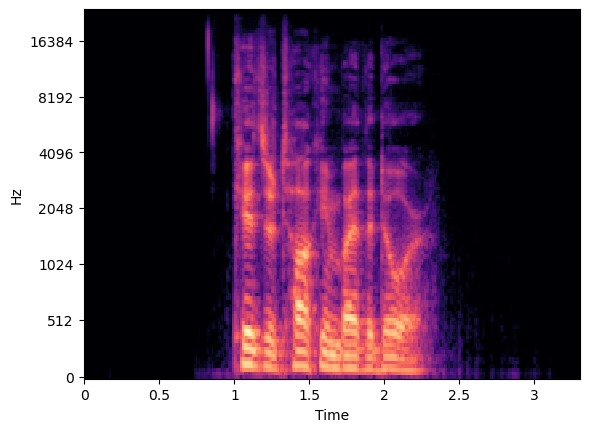

In [42]:
file_path = 'dataset/Actor_01/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(file_path, sr=None)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')

We see that the x-axis shows how the frequency distribution varies over time. The length of the spectrogram can vary based on how long the audio sample is. If we want fixed-size items, we should pad the spectrogram with zeroes. Let's compute the maximum length of the spectrogram.

In [46]:
spectrogram_lengths = []

for dir in os.listdir('dataset'):
    for file in os.listdir(f'dataset/{dir}'):
        y, sr = librosa.load(f'dataset/{dir}/{file}', sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        spectrogram_lengths.append(S_dB.shape[1])

max_spectrogram_length = max(spectrogram_lengths)
max_spectrogram_length

495

# Dataset for Spectrograms

We first need a dataset to abstract the loading of the spectrograms

In [45]:
class SpectrogramDataset(Dataset):
    def __init__(self):
        # Make an index of all the data files
        self.files = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                self.files.append(f'dataset/{dir}/{file}')
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        
        # Load file and create spectrogram
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Left-pad the spectrogram to the left with -80
        # -80 is the minimum threshold used by librosa for decibels
        padded = torch.zeros((1, 128, max_spectrogram_length)) - 80
        padded[0, :, :S_dB.shape[1]] = torch.tensor(S_dB)

        # Extract emotion from file path and one-hot encode it
        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(8)
        emotion_one_hot[emotion_idx] = 1.0

        return padded, emotion_one_hot

Let's also make some data loaders for the dataset.

In [75]:
batch_size = 64

dataset = SpectrogramDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# CNN for Classifying Spectrograms

Now, we can define a CNN architecture to classify the spectrograms based on emotions.
The CNN will have three convolutional-layers with max-pooling in between, followed by
global average pooing and a linear layer.

We'll also add an `extract_features` function to get the output of the GAP layer,
before the application of the linear layer. This will be used for early fusion.

In [47]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(AudioCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)
        self.output_dim = 512

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

    def extract_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return x

audio_cnn = AudioCNN(num_classes=8).to(device)

Now we need to train the CNN. We'll keep track of the train and test accuracy throughout the process.

In [51]:
# Train and test the CNN

num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(audio_cnn.parameters(), lr=0.1)

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    audio_cnn.train()
    train_loss = 0
    train_correct = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = audio_cnn(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
        train_loss += loss.item() * y.size(0)

    # Evaluation
    audio_cnn.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = audio_cnn(X)
            loss = criterion(outputs, y)
            test_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
            test_loss += loss.item() * y.size(0)

    train_loss /= len(train_ds)
    train_accuracy = train_correct / len(train_ds)
    test_loss /= len(test_ds)
    test_accuracy = test_correct / len(test_ds)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss}, Test Loss: {test_loss}\n")

[Epoch 1] Train Loss: 2.081474290953742, Test Loss: 2.0618484020233154

[Epoch 2] Train Loss: 2.076570577091641, Test Loss: 2.054106765323215

[Epoch 3] Train Loss: 2.0708904796176486, Test Loss: 2.0537421968248157

[Epoch 4] Train Loss: 2.068911870320638, Test Loss: 2.054121812184652

[Epoch 5] Train Loss: 2.0718469619750977, Test Loss: 2.055792066786024

[Epoch 6] Train Loss: 2.072187887297736, Test Loss: 2.0539455943637424

[Epoch 7] Train Loss: 2.0709664159350925, Test Loss: 2.05920590294732

[Epoch 8] Train Loss: 2.072950389650133, Test Loss: 2.0506387021806507

[Epoch 9] Train Loss: 2.0753173960579767, Test Loss: 2.051683717303806

[Epoch 10] Train Loss: 2.0718463791741266, Test Loss: 2.0525346332126193

[Epoch 11] Train Loss: 2.071479916572571, Test Loss: 2.050328334172567

[Epoch 12] Train Loss: 2.073909799257914, Test Loss: 2.0514223840501575

[Epoch 13] Train Loss: 2.0718629227744207, Test Loss: 2.059915542602539

[Epoch 14] Train Loss: 2.07168702284495, Test Loss: 2.05063422

We can plot the variation in loss and accuracy over time

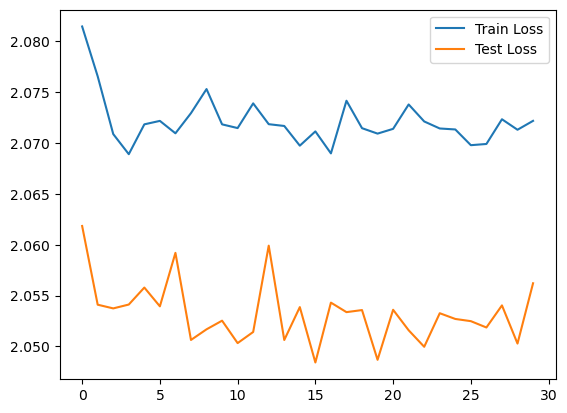

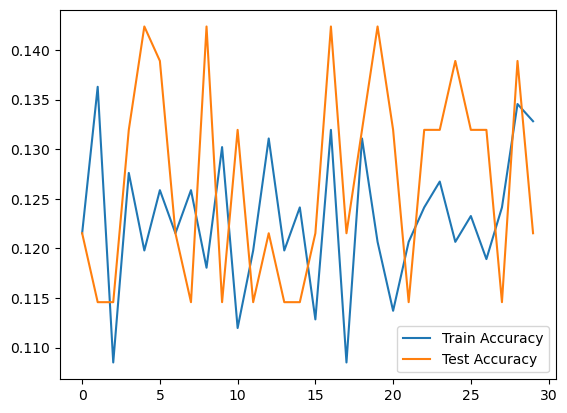

In [52]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.show()

We can also plot a confusion matrix for the CNN.

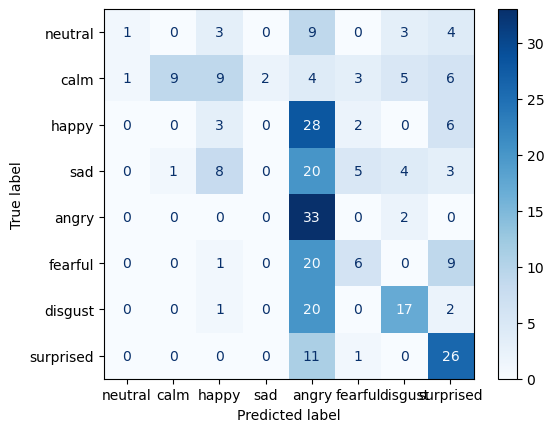

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

emotions = [
    'neutral',
    'calm',
    'happy',
    'sad',
    'angry',
    'fearful',
    'disgust',
    'surprised'
]

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Your test DataLoader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = audio_cnn(inputs)
        labels = labels.argmax(dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Generating Transcriptions with Whisper

For generating transcripts from the audio, we can use OpenAI's open-source Whisper model.

In [54]:
transcriber = whisper.load_model("base", device=device)

file_path = 'dataset/Actor_01/03-01-01-01-01-01-01.wav'
result = transcriber.transcribe(file_path)
print(result['text'])

 Kids are talking by the door.


Now let's generate transcripts for the entire dataset

In [55]:
model = whisper.load_model('tiny', device=device)
for dir in os.listdir('dataset'):
    for file in os.listdir(f'dataset/{dir}'):
        # If a transcript already exists, skip the file
        if os.path.exists(f'transcripts/{file}.txt'):
            continue

        result = model.transcribe(f'dataset/{dir}/{file}')
        open(f'transcripts/{file}.txt', 'w').write(result['text'])

Now we need a dataset to abstract away the loading of transcripts

In [56]:
class TranscriptDataset(Dataset):
    def __init__(self):
        # Make an index of file paths and transcripts
        self.files = []
        self.transcripts = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                if not os.path.exists(f'transcripts/{file}.txt'): continue # In case transcript has not been generated yet
                self.files.append(f'dataset/{dir}/{file}')
                self.transcripts.append(open(f'transcripts/{file}.txt').read())
                
        # Compute the vocabulary
        self.compute_vocab()

        # Max no of tokens in a transcript
        self.padded_size = max(len(x.lower().split()) for x in self.transcripts)

    def compute_vocab(self):
        vocab = {''}
        for transcript in self.transcripts:
            vocab.update(transcript.lower().split())

        self.vocab = list(vocab)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]

        # Extract label from file name
        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(len(emotions))
        emotion_one_hot[emotion_idx] = 1.0

        # Convert transcript to vocabulary indices
        transcript = self.transcripts[idx]
        encoded = [self.vocab.index(word) for word in transcript.lower().split()]
        encoded += [0] * (self.padded_size - len(encoded)) # Pad with zeroes

        return torch.tensor(encoded), emotion_one_hot

We also need a dataloader.


In [73]:
batch_size = 64

dataset = TranscriptDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# RNN for classifying transcripts

Now let's define the RNN architecture for classifying the transcripts
based on emotion. The RNN will first have an embedding layer, followed
by an LSTM and a linear layer.

We'll also add an `extract_features` function to get the output of the LSTM,
before the application of the linear layer. This will be used for early fusion.

In [58]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, num_classes=8, bidirectional=True):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, num_classes)
        self.output_dim = hidden_dim * direction_factor  # For early fusion

    def forward(self, x):  # x: [B, T] (token IDs)
        embedded = self.embedding(x)  # [B, T, E]
        lstm_out, _ = self.lstm(embedded)  # [B, T, H*D]
        last_hidden = lstm_out[:, -1, :]   # [B, H*D]
        logits = self.fc(last_hidden)      # [B, num_classes]
        return logits

    def extract_features(self, x):
        # For early fusion
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        return lstm_out[:, -1, :]  # [B, H*D]
    
text_rnn = TextRNN(len(dataset.vocab)).to(device)

Now let's train the model.

In [59]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_rnn.parameters(), lr=0.1)

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    text_rnn.train()
    train_loss = 0
    train_correct = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = text_rnn(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
        train_loss += loss.item() * y.size(0)

    # Evaluation
    text_rnn.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = text_rnn(X)
            loss = criterion(outputs, y)
            test_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
            test_loss += loss.item() * y.size(0)

    train_loss /= len(train_ds)
    train_accuracy = train_correct / len(train_ds)
    test_loss /= len(test_ds)
    test_accuracy = test_correct / len(test_ds)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss}, Test Loss: {test_loss}\n")

[Epoch 1] Train Loss: 8.404185440805223, Test Loss: 5.834678755866157

[Epoch 2] Train Loss: 3.541699012120565, Test Loss: 2.1831616825527616

[Epoch 3] Train Loss: 2.342337210973104, Test Loss: 2.232214583290948

[Epoch 4] Train Loss: 2.462135593096415, Test Loss: 2.4109118249681263

[Epoch 5] Train Loss: 2.3436093197928534, Test Loss: 2.1666012869940863

[Epoch 6] Train Loss: 2.2834227085113525, Test Loss: 2.2579662005106607

[Epoch 7] Train Loss: 2.301304340362549, Test Loss: 2.174954891204834

[Epoch 8] Train Loss: 2.739090879758199, Test Loss: 6.480410152011448

[Epoch 9] Train Loss: 6.638986044459873, Test Loss: 5.87595616446601

[Epoch 10] Train Loss: 5.095287415716383, Test Loss: 5.681552780999078

[Epoch 11] Train Loss: 4.741564909617106, Test Loss: 4.542953703138563

[Epoch 12] Train Loss: 2.987337999873691, Test Loss: 2.673690266079373

[Epoch 13] Train Loss: 3.0252748330434165, Test Loss: 3.2456671396891275

[Epoch 14] Train Loss: 3.297270033094618, Test Loss: 3.60416499773

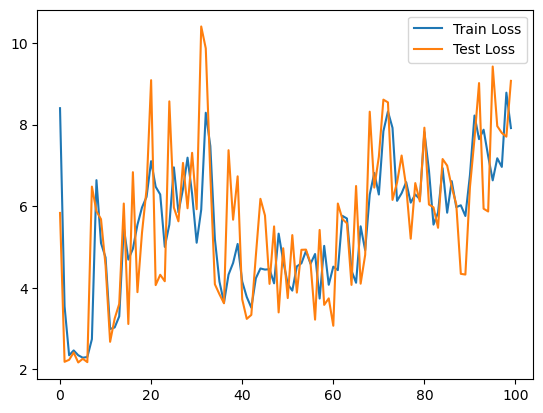

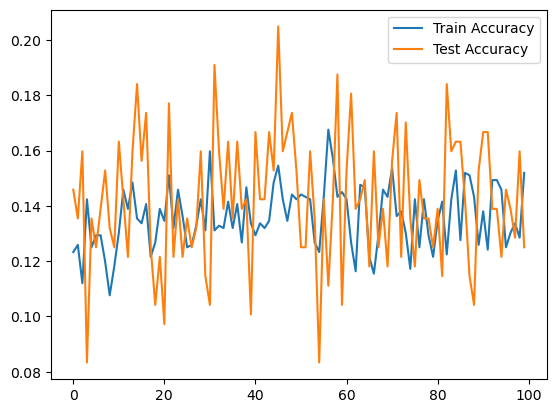

In [60]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.show()

Let's plot a confusion matrix for the RNN

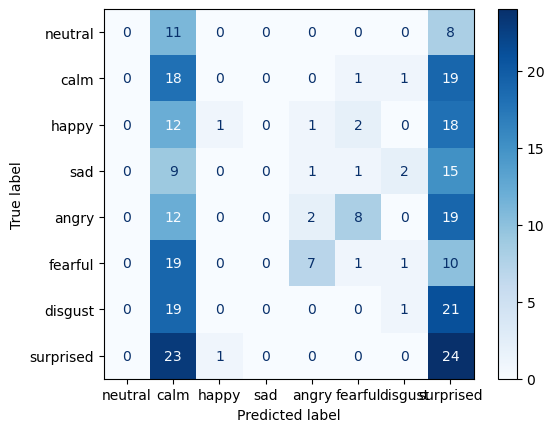

In [74]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Your test DataLoader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = text_rnn(inputs)
        labels = labels.argmax(dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Early Fusion Model

For early fusion, we'll use the `extract_features` methods of the CNN and RNN, and then pass the outputs through a linear layer.

In [77]:
class EarlyFusionModel(nn.Module):
    def __init__(self, audio_model, text_model, fusion_dim=256, num_classes=8):
        super().__init__()
        self.audio_model = audio_model
        self.text_model = text_model

        self.fusion = nn.Sequential(
            nn.Linear(audio_cnn.output_dim + text_model.output_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Linear(fusion_dim, num_classes)

    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model.extract_features(audio_input)
        text_feat = self.text_model.extract_features(text_input)

        fused = torch.cat((audio_feat, text_feat), dim=1)
        fused = self.fusion(fused)
        return self.classifier(fused)
    
# Freeze earlier models
for param in audio_cnn.parameters():
    param.requires_grad = False

for param in text_rnn.parameters():
    param.requires_grad = False

early_model = EarlyFusionModel(audio_cnn, text_rnn).to(device)

For the fusion models, we need a combined dataset that gives both spectrograms and transcripts.

In [63]:
# Gives both spectrogram and transcript

class CombinedDataset(Dataset):
    def __init__(self):
        self.files = []
        self.transcripts = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                if not os.path.exists(f'transcripts/{file}.txt'): continue
                self.files.append(f'dataset/{dir}/{file}')
                self.transcripts.append(open(f'transcripts/{file}.txt').read())

        self.compute_vocab()

    def compute_vocab(self):
        vocab = {''}
        for transcript in self.transcripts:
            vocab.update(transcript.lower().split())

        self.vocab = list(vocab)
        self.padded_size = max(len(x.lower().split()) for x in self.transcripts)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]

        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        padded = torch.zeros((1, 128, max_spectrogram_length)) - 80
        padded[0, :, :S_dB.shape[1]] = torch.tensor(S_dB)

        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(len(emotions))
        emotion_one_hot[emotion_idx] = 1.0

        transcript = self.transcripts[idx]
        encoded = [self.vocab.index(word) for word in transcript.lower().split()]
        encoded += [0] * (self.padded_size - len(encoded)) # Pad with zeroes

        return padded, torch.tensor(encoded), emotion_one_hot


In [78]:
batch_size = 64

dataset = CombinedDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Now let's train the early fusion model.

In [79]:
# Train the FFN part of the early fusion model

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(early_model.parameters(), lr=0.01)

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    early_model.train()
    train_loss = 0
    train_correct = 0

    for X1, X2, y in train_loader:
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = early_model(X1, X2)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
        train_loss += loss.item() * y.size(0)

    # Evaluation
    early_model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for X1, X2, y in test_loader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)
            outputs = early_model(X1, X2)
            loss = criterion(outputs, y)
            test_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
            test_loss += loss.item() * y.size(0)

    train_loss /= len(train_ds)
    train_accuracy = train_correct / len(train_ds)
    test_loss /= len(test_ds)
    test_accuracy = test_correct / len(test_ds)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss}, Test Loss: {test_loss}\n")


[Epoch 1] Train Loss: 2.0965149137708874, Test Loss: 2.0668926768832736

[Epoch 2] Train Loss: 1.9978984793027241, Test Loss: 2.018789874182807

[Epoch 3] Train Loss: 1.9474906192885504, Test Loss: 2.001258373260498

[Epoch 4] Train Loss: 1.905190236038632, Test Loss: 1.884741226832072

[Epoch 5] Train Loss: 1.8196098804473877, Test Loss: 1.8223577075534396

[Epoch 6] Train Loss: 1.7650552723142836, Test Loss: 1.7883074548509386

[Epoch 7] Train Loss: 1.7632427215576172, Test Loss: 1.7641873094770644

[Epoch 8] Train Loss: 1.695471121205224, Test Loss: 1.7301284472147624

[Epoch 9] Train Loss: 1.6514151162571378, Test Loss: 1.6695425245496962

[Epoch 10] Train Loss: 1.6213246583938599, Test Loss: 1.6480011145273845

[Epoch 11] Train Loss: 1.6379683547549777, Test Loss: 1.600442886352539

[Epoch 12] Train Loss: 1.588337567117479, Test Loss: 1.5994758870866563

[Epoch 13] Train Loss: 1.5699429776933458, Test Loss: 1.598148610856798

[Epoch 14] Train Loss: 1.5629733072386847, Test Loss: 1

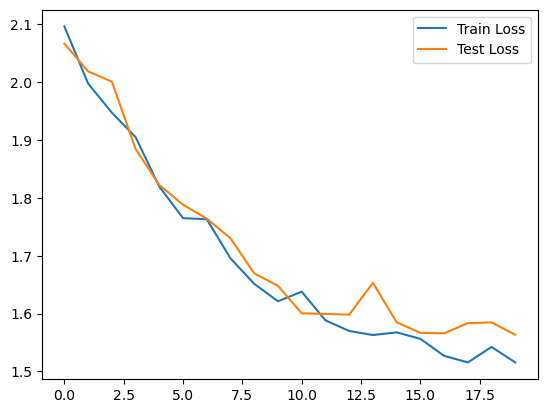

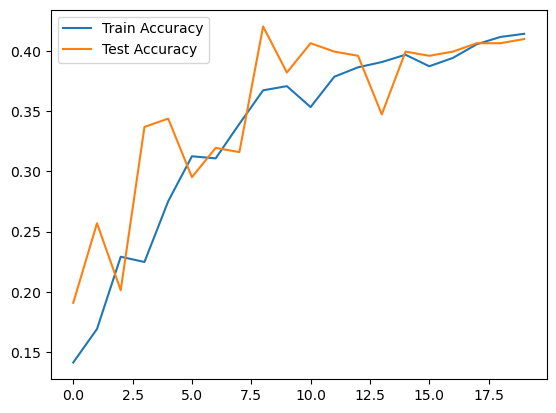

In [80]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.show()

Let's plot a confusion matrix.

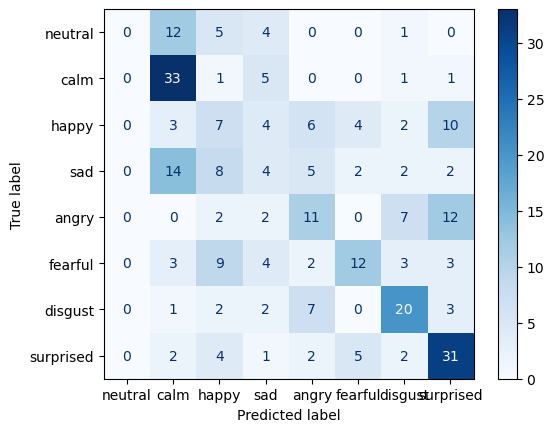

In [81]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X1, X2, y in test_loader:  # Your test DataLoader
        X1, X2, Y = X1.to(device), X2.to(device), y.to(device)

        outputs = early_model(X1, X2)
        labels = y.argmax(dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Late fusion model

For late fusion, we'll take the final logits as the average of the logits produced by the CNN and RNN.

In [82]:
class LateFusionModel(nn.Module):
    def __init__(self, audio_model, text_model):
        super().__init__()
        self.audio_model = audio_model
        self.text_model = text_model
    
    def forward(self, audio_input, text_input):
        audio_logits = self.audio_model(audio_input)
        text_logits = self.text_model(text_input)

        return (audio_logits + text_logits) / 2

late_model = LateFusionModel(audio_cnn, text_rnn)

We don't need to train this model. Let's test it.

In [83]:
# Test the late fusion model

test_loss = 0
test_correct = 0

with torch.no_grad():
    for X1, X2, y in test_loader:
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)
        outputs = late_model(X1, X2)
        test_correct += (outputs.argmax(1) == y.argmax(1)).sum().item()
        loss = criterion(outputs, y)
        test_loss += loss.item() * y.size(0)

test_loss /= len(test_ds)
test_accuracy = test_correct / len(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 4.22606012556288
Test Accuracy: 0.3194444444444444


Let's also plot a confusion matrix.

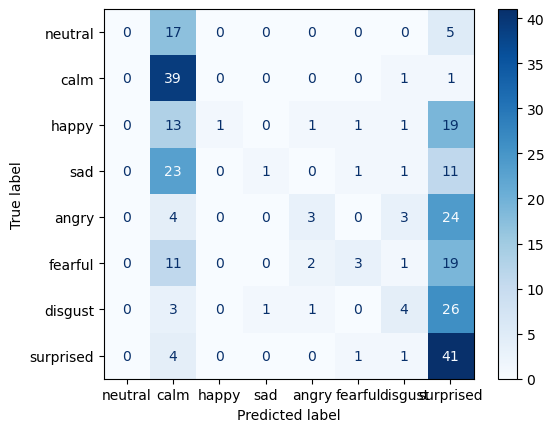

In [84]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X1, X2, y in test_loader:  # Your test DataLoader
        X1, X2, Y = X1.to(device), X2.to(device), y.to(device)

        outputs = late_model(X1, X2)
        labels = y.argmax(dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='d')
plt.show()